# Materials Project Deep Research - Scoping Phase

This notebook implements the **scoping phase** of a Materials Project deep research workflow.

## Overview

The scoping phase:
1. **Clarifies** the user's materials research request (chemical systems, properties, constraints)
2. **Validates** connections to external resources (MP API, optional)
3. **Generates** a structured research brief optimized for Materials Project queries

## External Resource Integration

| Resource | This Notebook | Later Notebooks |
|----------|---------------|------------------|
| **MP API** | Connection validation | Full data queries |
| **pymatgen** | Structure validation | Analysis & I/O |
| **atomate2** | Not used | Workflow generation |

## Architecture

```
User Input → Clarify (MP-specific) → Write Research Brief → [To Research Phase]
                    ↓
              Validate MP Connection (optional)
```

In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

## 1. Environment Setup & Connection Validation

First, let's validate our connections to external resources. This is **optional** for the scoping phase but helps catch configuration issues early.

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

# ===== CONFIGURATION =====
# These can be set via environment variables or directly here

# Materials Project API Key (get yours at https://next-gen.materialsproject.org/api)
MP_API_KEY = os.environ.get("MP_API_KEY", None)

# LLM Configuration
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", None)
LLM_MODEL = os.environ.get("LLM_MODEL", "gpt-4o-mini")

# LangSmith (optional, for evaluation)
LANGSMITH_API_KEY = os.environ.get("LANGSMITH_API_KEY", None)

print("Configuration Status:")
print(f"  MP_API_KEY: {'✓ Set' if MP_API_KEY else '✗ Not set (optional for scoping)'}")
print(f"  OPENAI_API_KEY: {'✓ Set' if OPENAI_API_KEY else '✗ Not set (required)'}")
print(f"  LANGSMITH_API_KEY: {'✓ Set' if LANGSMITH_API_KEY else '✗ Not set (optional)'}")
print(f"  LLM_MODEL: {LLM_MODEL}")

Configuration Status:
  MP_API_KEY: ✓ Set
  OPENAI_API_KEY: ✓ Set
  LANGSMITH_API_KEY: ✓ Set
  LLM_MODEL: gpt-4o-mini


In [3]:
# ===== VALIDATE MATERIALS PROJECT CONNECTION (Optional) =====

def validate_mp_connection():
    """Test connection to Materials Project API and return database info."""
    try:
        from mp_api.client import MPRester
        
        with MPRester(MP_API_KEY) as mpr:
            # Get database version
            db_version = mpr.get_database_version()
            
            # Get available fields (for schema validation)
            available_fields = mpr.materials.summary.available_fields
            
            # Test a simple query
            test_doc = mpr.materials.summary.search(
                material_ids=["mp-149"],  # Silicon
                fields=["material_id", "formula_pretty", "band_gap"]
            )
            
            return {
                "status": "connected",
                "database_version": db_version,
                "available_fields_count": len(available_fields),
                "test_query": f"{test_doc[0].formula_pretty} (mp-149): band_gap = {test_doc[0].band_gap} eV"
            }
    except ImportError:
        return {"status": "mp-api not installed", "message": "Run: pip install mp-api"}
    except Exception as e:
        return {"status": "error", "message": str(e)}

# Run validation if API key is set
if MP_API_KEY:
    mp_status = validate_mp_connection()
    print("\nMaterials Project Connection:")
    for key, value in mp_status.items():
        print(f"  {key}: {value}")
else:
    print("\nSkipping MP validation (no API key set)")
    print("Note: MP connection is optional for scoping, required for research phase.")

Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]


Materials Project Connection:
  status: connected
  database_version: 2025.09.25
  available_fields_count: 69
  test_query: Si (mp-149): band_gap = 0.6105 eV


In [4]:
# ===== VALIDATE MATERIALS PROJECT CONNECTION (Optional) =====

def validate_mp_connection():
    """Test connection to Materials Project API and return database info."""
    try:
        from mp_api.client import MPRester
        
        with MPRester(MP_API_KEY) as mpr:
            # Get database version
            db_version = mpr.get_database_version()
            
            # Get available fields (for schema validation)
            available_fields = mpr.materials.summary.available_fields            
            
            # Test a simple query
            test_doc = mpr.materials.summary.search(
                material_ids=["mp-149"],  # Silicon
                fields=["material_id", "formula_pretty", "band_gap"]
            )
            
            return {
                "status": "connected",
                "database_version": db_version,
                "available_fields_count": len(available_fields),
                "test_query": f"{test_doc[0].formula_pretty} (mp-149): band_gap = {test_doc[0].band_gap} eV"
            }
    except ImportError:
        return {"status": "mp-api not installed", "message": "Run: pip install mp-api"}
    except Exception as e:
        return {"status": "error", "message": str(e)}

# Run validation if API key is set
if MP_API_KEY:
    mp_status = validate_mp_connection()
    print("\nMaterials Project Connection:")
    for key, value in mp_status.items():
        print(f"  {key}: {value}")
else:
    print("\nSkipping MP validation (no API key set)")
    print("Note: MP connection is optional for scoping, required for research phase.")

Retrieving SummaryDoc documents: 100%|██████████| 1/1 [00:00<00:00, 21732.15it/s]


Materials Project Connection:
  status: connected
  database_version: 2025.09.25
  available_fields_count: 69
  test_query: Si (mp-149): band_gap = 0.6105 eV


In [5]:
# ===== VALIDATE PYMATGEN (Optional) =====

def validate_pymatgen():
    """Test pymatgen installation and basic functionality."""
    try:
        import importlib.metadata as metadata
        from pymatgen.core import Structure, Composition
        
        # Test composition parsing
        comp = Composition("LiCoO2")
        
        return {
            "status": "available",
            "version": metadata.version("pymatgen"),
            "test": f"Parsed LiCoO2: {comp.reduced_formula}, {comp.num_atoms} atoms"
        }
    except ImportError:
        return {"status": "not installed", "message": "Run: pip install pymatgen"}
    except Exception as e:
        return {"status": "error", "message": str(e)}

pmg_status = validate_pymatgen()
print("\npymatgen Status:")
for key, value in pmg_status.items():
    print(f"  {key}: {value}")


pymatgen Status:
  status: available
  version: 2025.10.7
  test: Parsed LiCoO2: LiCoO2, 4.0 atoms


## 2. State and Schemas


Define the state objects and schemas for the Materials Project research workflow.

Key additions for Materials Project:
- `chemical_system`: Elements/compositions being studied
- `target_properties`: Properties to query/calculate
- `stability_threshold`: e_above_hull cutoff
- `dft_level`: Computational method preference

In [6]:
%%writefile ../src/mp_deep_research/state_scope.py

"""State Definitions and Pydantic Schemas for Materials Project Research Scoping.

This defines the state objects and structured schemas used for
the materials research agent scoping workflow.
"""

import operator
from typing_extensions import Annotated, Sequence, Optional, List, Literal

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field, ConfigDict

# ===== MATERIALS-SPECIFIC ENUMS =====

DFTLevel = Literal["GGA", "GGA+U", "r2SCAN", "HSE06", "any"]
ResearchType = Literal["screening", "discovery", "property_calculation", "structure_prediction", "comparison"]

# ===== STATE DEFINITIONS =====

class PropertyThreshold(BaseModel):
    """Schema for numeric property constraints."""
    
    model_config = ConfigDict(extra="forbid")
    
    property_name: str = Field(
        description="Property name in MP schema (e.g., band_gap, energy_above_hull)."
    )
    min_value: Optional[float] = Field(
        default=None,
        description="Minimum allowed value for the property (inclusive)."
    )
    max_value: Optional[float] = Field(
        default=None,
        description="Maximum allowed value for the property (inclusive)."
    )
    unit: Optional[str] = Field(
        default=None,
        description="Unit for the property values (e.g., eV, eV/atom)."
    )

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass


class MaterialsResearchState(MessagesState):
    """
    Main state for the Materials Project multi-agent research system.
    
    Extends MessagesState with materials-specific fields for research coordination.
    """
    
    # ===== SCOPING FIELDS =====
    # Research brief generated from user conversation
    research_brief: Optional[str] = None
    
    # ===== MATERIALS-SPECIFIC FIELDS =====
    # Chemical system being studied (e.g., "Li-Co-O", ["Li", "Fe", "P", "O"])
    chemical_system: Optional[str] = None
    # Target properties to investigate
    target_properties: List[str] = []
    # Stability threshold (e_above_hull in eV/atom)
    stability_threshold: Optional[float] = 0.025  # Default: 25 meV/atom
    # DFT level of theory preference
    dft_level: DFTLevel = "any"
    # Type of research being conducted
    research_type: Optional[ResearchType] = None
    # Quantitative thresholds specified by user
    property_thresholds: List[PropertyThreshold] = []
    
    # ===== COORDINATION FIELDS =====
    # Messages exchanged with the supervisor agent
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages] = []
    
    # ===== RESEARCH FIELDS (used in later phases) =====
    # Material IDs found during research
    material_ids: List[str] = []
    # Raw unprocessed research notes
    raw_notes: Annotated[List[str], operator.add] = []
    # Processed notes ready for report generation
    notes: Annotated[List[str], operator.add] = []
    # Final research report
    final_report: Optional[str] = None
    # Generated visualization paths
    visualizations: List[str] = []
    # Generated workflow code (for simulation phase)
    workflow_code: Optional[str] = None

# Alias for backward compatibility
AgentState = MaterialsResearchState

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions - Materials Project specific."""
    
    model_config = ConfigDict(extra="forbid")
    
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question about their materials research request.",
    )
    question: str = Field(
        description="A question to clarify the materials research scope (chemical system, properties, thresholds, etc.)",
    )
    verification: str = Field(
        description="Verification message confirming the research scope and approach.",
    )
    # Materials-specific extracted information
    detected_chemical_system: Optional[str] = Field(
        default=None,
        description="Chemical system detected from user input (e.g., 'Li-Co-O')"
    )
    detected_properties: List[str] = Field(
        default=[],
        description="Properties detected from user input (e.g., ['band_gap', 'formation_energy'])"
    )
    detected_stability_threshold: Optional[float] = Field(
        default=None,
        description="Stability threshold detected from user input (e_above_hull in eV/atom)"
    )
    detected_dft_level: Optional[DFTLevel] = Field(
        default=None,
        description="DFT level of theory preference detected from user input"
    )

class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation - Materials Project specific."""
    
    model_config = ConfigDict(extra="forbid")
    
    research_brief: str = Field(
        description="A detailed research question optimized for Materials Project database queries.",
    )
    chemical_system: Optional[str] = Field(
        default=None,
        description="The chemical system to investigate (e.g., 'Li-Fe-P-O')"
    )
    target_properties: List[str] = Field(
        default=[],
        description="List of properties to query from MP (e.g., ['band_gap', 'formation_energy_per_atom'])"
    )
    property_thresholds: List[PropertyThreshold] = Field(
        default_factory=list,
        description="Quantitative thresholds for properties with min/max bounds."
    )
    stability_threshold: Optional[float] = Field(
        default=0.025,
        description="Stability threshold (energy_above_hull) in eV/atom"
    )
    dft_level: DFTLevel = Field(
        default="any",
        description="Preferred DFT level of theory (GGA, GGA+U, r2SCAN, HSE06, any)"
    )
    research_type: str = Field(
        default="screening",
        description="Type of research: screening, discovery, property_calculation, structure_prediction, comparison"
    )
    requires_simulation: bool = Field(
        default=False,
        description="Whether this research will require DFT simulation workflows"
    )
    suggested_mp_query: Optional[str] = Field(
        default=None,
        description="Suggested MP API query structure for this research"
    )

Overwriting ../src/mp_deep_research/state_scope.py


## 3. Materials Project Prompts

Define prompts specifically tuned for materials science research clarification and brief generation.

In [8]:
from mp_deep_research.prompts import (
    clarify_with_user_instructions,
    transform_messages_into_research_topic_prompt,
    BRIEF_CRITERIA_PROMPT,
    BRIEF_HALLUCINATION_PROMPT,
)


## 4. Scope Research Workflow

Now we'll create the scoping workflow with Materials Project-specific logic.

In [16]:
# %%writefile ../src/mp_deep_research/research_agent_scope.py

"""User Clarification and Research Brief Generation for Materials Project.

This module implements the scoping phase of the materials research workflow:
1. Assess if the user's request needs clarification (chemical system, properties, thresholds)
2. Validate MP-specific requirements
3. Generate a detailed research brief optimized for MP queries
"""

from datetime import datetime
from typing import Literal
import os

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

# Import from our modules
try:
    from mp_deep_research.prompts import (
        clarify_with_user_instructions, 
        transform_messages_into_research_topic_prompt
    )
    from mp_deep_research.state_scope import (
        MaterialsResearchState, 
        ClarifyWithUser, 
        ResearchQuestion, 
        AgentInputState
    )
except ImportError:
    # For notebook execution
    from materials_project_prompts_v3_final import clarify_with_user_instructions, transform_messages_into_research_topic_prompt
    from state_scope import MaterialsResearchState, ClarifyWithUser, ResearchQuestion, AgentInputState

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %d, %Y")

def validate_chemical_system(system: str) -> bool:
    """Validate that a chemical system string is properly formatted for MP."""
    if not system:
        return False
    # MP format: Element1-Element2-Element3 (e.g., "Li-Co-O")
    elements = system.split("-")
    # Basic validation: each part should be 1-2 characters, capitalized
    return all(len(e) <= 2 and e[0].isupper() for e in elements)

# ===== CONFIGURATION =====

# Initialize model - configurable via environment variable
LLM_MODEL = os.environ.get("LLM_MODEL", "gpt-4o-mini")
model = init_chat_model(model=f"openai:{LLM_MODEL}", temperature=0.0)

# ===== WORKFLOW NODES =====

def clarify_with_user(state: MaterialsResearchState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Determine if the user's materials research request needs clarification.
    
    Materials-specific checks:
    - Chemical system specified?
    - Properties quantified (not vague terms like 'good')?
    - Stability requirements clear?
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with materials-specific clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={
                "messages": [AIMessage(content=response.question)],
                # Store any detected information
                "chemical_system": response.detected_chemical_system,
                "target_properties": response.detected_properties or []
            }
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={
                "messages": [AIMessage(content=response.verification)],
                "chemical_system": response.detected_chemical_system,
                "target_properties": response.detected_properties or []
            }
        )

def write_research_brief(state: MaterialsResearchState):
    """
    Transform conversation into a Materials Project-optimized research brief.
    
    Outputs:
    - Structured research question
    - Chemical system in MP format
    - Target properties list
    - Property thresholds
    - Suggested MP API query
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Validate chemical system format
    chemical_system = response.chemical_system
    if chemical_system and not validate_chemical_system(chemical_system):
        # Try to fix common issues
        chemical_system = chemical_system.replace(" ", "-").replace(",", "-")
    
    # Update state with generated research brief and MP-specific fields
    return {
        "research_brief": response.research_brief,
        "chemical_system": chemical_system or state.get("chemical_system"),
        "target_properties": response.target_properties or state.get("target_properties", []),
        "property_thresholds": response.property_thresholds,
        "research_type": response.research_type,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }

# ===== GRAPH CONSTRUCTION =====

def build_scoping_workflow():
    """Build and compile the scoping workflow."""
    # Build the scoping workflow
    builder = StateGraph(MaterialsResearchState, input_schema=AgentInputState)

    # Add workflow nodes
    builder.add_node("clarify_with_user", clarify_with_user)
    builder.add_node("write_research_brief", write_research_brief)

    # Add workflow edges
    builder.add_edge(START, "clarify_with_user")
    builder.add_edge("write_research_brief", END)

    # Compile the workflow
    return builder.compile()

# Create the compiled workflow
scope_research = build_scoping_workflow()

## 5. Test the Scoping Workflow

Let's test with materials science specific examples.

In [17]:
# Import the workflow (for notebook execution)
from datetime import datetime
from typing import Literal
import json

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from mp_deep_research import state_scope, research_agent_scope

In [18]:
# Test Example 1: Vague request (should ask for clarification)
test_input_vague = {
    "messages": [
        HumanMessage(content="I want to find good battery cathode materials")
    ]
}

print("=" * 60)
print("TEST 1: Vague Request (should ask for clarification)")
print("=" * 60)
print(f"Input: {test_input_vague['messages'][0].content}")
print()

result = scope_research.invoke(test_input_vague)
print("Response:")
print(result["messages"][-1].content)
print()
print(f"Research Brief Generated: {result.get('research_brief') is not None}")

TEST 1: Vague Request (should ask for clarification)
Input: I want to find good battery cathode materials

Response:
To better assist you in finding good battery cathode materials, could you please specify:

1. The specific chemical system or composition you are interested in (e.g., Li-ion, Na-ion)?
2. The target properties you are looking for (e.g., high capacity, stability, conductivity)?
3. Any specific computational methodology preferences (e.g., GGA, GGA+U)?
4. Quantitative thresholds for terms like 'good' or 'stable' (e.g., capacity > 180 mAh/g, e_above_hull < 25 meV/atom)?

Research Brief Generated: False


In [19]:
# Test Example 2: Specific request (should proceed to research brief)
# Refresh workflow in case schema changed above
exec(open('../src/mp_deep_research/state_scope.py').read().replace('%%writefile ../src/mp_deep_research/state_scope.py', ''))
exec(open('../src/mp_deep_research/research_agent_scope.py').read().replace('%%writefile ../src/mp_deep_research/research_agent_scope.py', ''))

test_input_specific = {
    "messages": [
        HumanMessage(content="""I need to find lithium cobalt oxide cathode materials with:
        - Band gap between 2-4 eV
        - Formation energy below -2 eV/atom
        - Thermodynamically stable (e_above_hull < 25 meV/atom)
        - Layered structure type
        """)
    ]
}

print("=" * 60)
print("TEST 2: Specific Request (should generate research brief)")
print("=" * 60)
print(f"Input: {test_input_specific['messages'][0].content}")
print()

result = scope_research.invoke(test_input_specific)
print("Response:")
print(result["messages"][-1].content)
print()
print(f"Research Brief: {result.get('research_brief', 'Not generated')[:500]}...")
print()
print(f"Chemical System: {result.get('chemical_system')}")
print(f"Target Properties: {result.get('target_properties')}")
print("Property Thresholds:")
for threshold in result.get("property_thresholds") or []:
    print(f"  - {threshold}")
print(f"Research Type: {result.get('research_type')}")

TEST 2: Specific Request (should generate research brief)
Input: I need to find lithium cobalt oxide cathode materials with:
        - Band gap between 2-4 eV
        - Formation energy below -2 eV/atom
        - Thermodynamically stable (e_above_hull < 25 meV/atom)
        - Layered structure type
        

Response:
Thank you for providing detailed criteria for your research on lithium cobalt oxide cathode materials. We will focus on finding materials with a band gap between 2-4 eV, formation energy below -2 eV/atom, and thermodynamic stability (e_above_hull < 25 meV/atom) with a layered structure type. We will query the Materials Project database and perform computational analysis to identify suitable candidates. We will now begin the research process.

Research Brief: I am investigating lithium cobalt oxide cathode materials for lithium-ion batteries. My focus is on identifying candidates with a band gap between 2-4 eV, a formation energy below -2 eV/atom, and thermodynamic stabili

In [20]:
# Test Example 3: Multi-turn conversation
test_input_multiturn = {
    "messages": [
        HumanMessage(content="I want to find stable thermoelectric materials"),
        AIMessage(content="""To help you find suitable thermoelectric materials, I need some clarification:

1. What chemical system are you interested in? (e.g., Bi-Te, Pb-Te, half-Heuslers)
2. What temperature range are you targeting? (This affects the optimal band gap)
3. By 'stable', do you mean:
   - Thermodynamically stable (e_above_hull < 25 meV/atom)?
   - Or including metastable phases?
4. Do you have any constraints on toxic elements (Pb, Cd, etc.)?"""),
        HumanMessage(content="""I'm interested in Bi-Te based materials for room temperature applications.
        Include metastable phases up to 50 meV/atom above hull.
        No toxic element constraints.""")
    ]
}

print("=" * 60)
print("TEST 3: Multi-turn Conversation")
print("=" * 60)

result = scope_research.invoke(test_input_multiturn)
print("Final Response:")
print(result["messages"][-1].content)
print()
if result.get('research_brief'):
    print(f"Research Brief: {result['research_brief'][:500]}...")
    print()
    print(f"Chemical System: {result.get('chemical_system')}")
    print(f"Property Thresholds: {result.get('property_thresholds')}")

TEST 3: Multi-turn Conversation
Final Response:
Thank you for providing the details. We will proceed with researching Bi-Te based thermoelectric materials suitable for room temperature applications, considering both stable and metastable phases up to 50 meV/atom above the hull. We will utilize the Materials Project database to identify potential candidates and analyze their thermoelectric properties. The research process will now begin.

Research Brief: I am investigating Bi-Te based thermoelectric materials suitable for room temperature applications. I aim to identify both stable and metastable phases, considering those up to 50 meV/atom above the convex hull. My focus is on materials that exhibit promising thermoelectric properties, such as a suitable band gap for room temperature performance. I have no constraints regarding toxic elements, and I am open to exploring various DFT methods to ensure comprehensive analysis....

Chemical System: Bi-Te
Property Thresholds: [PropertyThresho

## 6. Visualize the Workflow

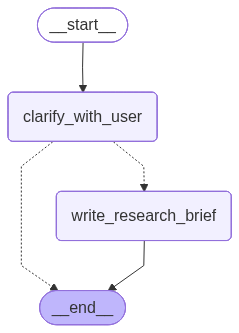

In [21]:
from IPython.display import Image, display

try:
    display(Image(scope_research.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not render graph: {e}")
    print("\nWorkflow structure:")
    print("START → clarify_with_user → [write_research_brief | END]")
    print("write_research_brief → END")

## 7. Evaluation Dataset

Create materials-specific evaluation examples.

In [22]:
# Materials-specific evaluation conversations and criteria

# Example 1: Battery cathode screening
conversation_1 = [
    HumanMessage(content="Find Li-ion battery cathode materials with high capacity"),
    AIMessage(content="""To find suitable cathode materials, I need clarification:
    1. What do you define as 'high capacity'? (e.g., > 150 mAh/g, > 200 mAh/g?)
    2. Do you have voltage requirements?
    3. Should I include only stable materials (e_above_hull < 25 meV/atom)?"""),
    HumanMessage(content="""Capacity > 180 mAh/g, voltage > 3.5V vs Li/Li+.
    Include metastable phases up to 50 meV/atom.
    Focus on layered oxides.""")
]

criteria_1 = [
    "Chemical system includes Li",
    "Capacity threshold > 180 mAh/g",
    "Voltage threshold > 3.5 V",
    "Stability threshold 50 meV/atom",
    "Layered oxide structure type",
]

# Example 2: Thermoelectric materials discovery
conversation_2 = [
    HumanMessage(content="""I need to find new thermoelectric materials in the Bi-Te-Se system.
    Requirements:
    - Band gap 0.1-0.3 eV (for room temperature operation)
    - Heavy elements preferred (low thermal conductivity)
    - Stable or near-stable (e_above_hull < 30 meV/atom)
    - Include r2SCAN level data if available""")
]

criteria_2 = [
    "Chemical system Bi-Te-Se",
    "Band gap range 0.1-0.3 eV",
    "Stability threshold 30 meV/atom",
    "r2SCAN functional preference mentioned",
    "Room temperature application context",
]

# Example 3: Catalyst screening
conversation_3 = [
    HumanMessage(content="Find transition metal oxide catalysts for oxygen evolution reaction"),
    AIMessage(content="""For OER catalyst screening, I need to clarify:
    1. Which transition metals? (Fe, Co, Ni, Mn, etc.)
    2. Any structure preferences? (perovskite, spinel, rutile?)
    3. Stability requirements in acidic or alkaline conditions?"""),
    HumanMessage(content="""Focus on Fe, Co, Ni oxides.
    Perovskite and spinel structures.
    Alkaline conditions, so include metastable phases.
    Need materials with moderate band gaps (1-3 eV) for conductivity.""")
]

criteria_3 = [
    "Elements include Fe, Co, Ni, O",
    "Perovskite structure mentioned",
    "Spinel structure mentioned",
    "Band gap range 1-3 eV",
    "OER/catalyst application context",
]

print("Evaluation examples created:")
print(f"  Example 1: Battery cathode screening ({len(criteria_1)} criteria)")
print(f"  Example 2: Thermoelectric discovery ({len(criteria_2)} criteria)")
print(f"  Example 3: Catalyst screening ({len(criteria_3)} criteria)")

Evaluation examples created:
  Example 1: Battery cathode screening (5 criteria)
  Example 2: Thermoelectric discovery (5 criteria)
  Example 3: Catalyst screening (5 criteria)


In [23]:
# Create LangSmith dataset (if API key available)

if LANGSMITH_API_KEY:
    from langsmith import Client

    langsmith_client = Client(api_key=LANGSMITH_API_KEY)

    dataset_name = "mp_deep_research_scoping"
    
    if not langsmith_client.has_dataset(dataset_name=dataset_name):
        dataset = langsmith_client.create_dataset(
            dataset_name=dataset_name,
            description="Materials Project research brief evaluation dataset",
        )

        langsmith_client.create_examples(
            dataset_id=dataset.id,
            examples=[
                {"inputs": {"messages": conversation_1}, "outputs": {"criteria": criteria_1}},
                {"inputs": {"messages": conversation_2}, "outputs": {"criteria": criteria_2}},
                {"inputs": {"messages": conversation_3}, "outputs": {"criteria": criteria_3}},
            ],
        )
        print(f"Created dataset: {dataset_name}")
    else:
        print(f"Dataset already exists: {dataset_name}")
else:
    print("LangSmith API key not set - skipping dataset creation")

Dataset already exists: mp_deep_research_scoping


## 8. Run Evaluation

In [24]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

class MaterialsCriteria(BaseModel):
    """Evaluation result for a materials-specific criterion."""
    criteria_text: str = Field(description="The criterion being evaluated")
    reasoning: str = Field(description="Detailed reasoning for the evaluation")
    is_captured: bool = Field(description="Whether the criterion is captured in the brief")

def evaluate_materials_criteria(outputs: dict, reference_outputs: dict):
    """Evaluate whether the research brief captures all materials-specific criteria."""
    research_brief = outputs.get("research_brief", "")
    success_criteria = reference_outputs.get("criteria", [])
    
    if not research_brief:
        return {
            "key": "materials_criteria_score",
            "score": 0.0,
            "comment": "No research brief generated"
        }

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    structured_model = model.with_structured_output(MaterialsCriteria)
    
    responses = structured_model.batch([
        [HumanMessage(content=BRIEF_CRITERIA_PROMPT.format(
            research_brief=research_brief,
            criterion=criterion
        ))]
        for criterion in success_criteria
    ])
    
    evaluations = [
        MaterialsCriteria(
            criteria_text=criterion,
            reasoning=response.reasoning,
            is_captured=response.is_captured
        )
        for criterion, response in zip(success_criteria, responses)
    ]
    
    captured_count = sum(1 for e in evaluations if e.is_captured)
    total_count = len(evaluations)
    
    return {
        "key": "materials_criteria_score",
        "score": captured_count / total_count if total_count > 0 else 0.0,
        "individual_evaluations": [
            {
                "criteria": e.criteria_text,
                "captured": e.is_captured,
                "reasoning": e.reasoning
            }
            for e in evaluations
        ]
    }

print("Evaluator defined: evaluate_materials_criteria")

Evaluator defined: evaluate_materials_criteria


In [25]:
# Run evaluation on example 2 (specific request)
print("Running evaluation on Example 2 (Thermoelectric materials)...")
print()

# Generate the brief
result = scope_research.invoke({"messages": conversation_2})

# Evaluate
eval_result = evaluate_materials_criteria(
    outputs={"research_brief": result.get("research_brief", "")},
    reference_outputs={"criteria": criteria_2}
)

print(f"Overall Score: {eval_result['score']:.1%}")
print()
print("Individual Criteria:")
for item in eval_result.get("individual_evaluations", []):
    status = "✓" if item["captured"] else "✗"
    print(f"  {status} {item['criteria']}")
    print(f"    Reasoning: {item['reasoning'][:100]}...")
    print()

Running evaluation on Example 2 (Thermoelectric materials)...

Overall Score: 100.0%

Individual Criteria:
  ✓ Chemical system Bi-Te-Se
    Reasoning: The research brief explicitly mentions the investigation of thermoelectric materials within the Bi-T...

  ✓ Band gap range 0.1-0.3 eV
    Reasoning: The research brief explicitly mentions the focus on identifying compounds with a band gap between 0....

  ✓ Stability threshold 30 meV/atom
    Reasoning: The research brief explicitly mentions the stability criterion by stating, "Stability is crucial, so...

  ✓ r2SCAN functional preference mentioned
    Reasoning: The research brief explicitly states a preference for data calculated at the r2SCAN level of theory....

  ✓ Room temperature application context
    Reasoning: The research brief explicitly mentions the focus on identifying compounds suitable for room temperat...



## 9. Next Steps

This scoping notebook sets up the foundation for Materials Project deep research. The next notebooks in the series will:

### Notebook 2: Research Phase
- **Full MP API Integration**: Query materials based on research brief
- **pymatgen Analysis**: Structure analysis, phase diagrams
- **Visualization**: Band structures, DOS plots, phase diagrams

### Notebook 3: Simulation Phase  
- **atomate2 Workflows**: Generate executable DFT workflows
- **Structure Prediction**: For materials not in database
- **Synthesis Routes**: Suggest experimental approaches

### Notebook 4: Report Generation
- **Data Provenance**: Track DFT vs experimental sources
- **Visualizations**: Embedded plots and diagrams
- **Reproducibility**: Complete workflow documentation

In [27]:
# Summary of what we've built
print("Materials Project Scoping Workflow Summary")
print("=" * 50)
print()
print("Components Created:")
print("  1. MaterialsResearchState - Extended state with MP-specific fields")
print("  2. ClarifyWithUser schema - Extracts chemical systems, properties")
print("  3. ResearchQuestion schema - Structured brief with MP query hints")
print("  4. clarify_with_user node - Enforces quantitative thresholds")
print("  5. write_research_brief node - Generates MP-optimized briefs")
print()
print("External Resources:")
print("  - MP API: Connection validated (if key provided)")
print("  - pymatgen: Available for composition parsing")
print("  - atomate2: To be used in Simulation notebook")
print()
print("Files Generated:")
print("  - ../src/mp_deep_research/state_scope.py")
print("  - ../src/mp_deep_research/prompts.py")
print("  - ../src/mp_deep_research/research_agent_scope.py")

Materials Project Scoping Workflow Summary

Components Created:
  1. MaterialsResearchState - Extended state with MP-specific fields
  2. ClarifyWithUser schema - Extracts chemical systems, properties
  3. ResearchQuestion schema - Structured brief with MP query hints
  4. clarify_with_user node - Enforces quantitative thresholds
  5. write_research_brief node - Generates MP-optimized briefs

External Resources:
  - MP API: Connection validated (if key provided)
  - pymatgen: Available for composition parsing
  - atomate2: To be used in Simulation notebook

Files Generated:
  - ../src/mp_deep_research/state_scope.py
  - ../src/mp_deep_research/prompts.py
  - ../src/mp_deep_research/research_agent_scope.py
